## Оптимизация маркетинговых затрат

В привлечение пользователей pазвлекательного приложения Procrastinate Pro+ было вложено много денежных средств, но несколько прошлых месяцев бизнес постоянно нес убытки. Необходимо разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

 **Описание данных**
 
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузим данные и подготовим их к анализу


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
visits = pd.read_csv('/datasets/visits_info_short.csv') # чтение файла с данными и сохранение в visits
purchases = pd.read_csv('/datasets/orders_info_short.csv') # чтение файла с данными и сохранение в orders
ad_costs = pd.read_csv('/datasets/costs_info_short.csv') # чтение файла с данными и сохранение в costs
display(visits.head(10))
display()
display(purchases.head(10))
display()
display(ad_costs.head(10))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [4]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [5]:
visits.isna().sum() # найдем строки с пропусками

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [6]:
purchases.isna().sum() # найдем строки с пропусками

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [7]:
ad_costs.isna().sum() # найдем строки с пропусками

dt         0
Channel    0
costs      0
dtype: int64

In [8]:
visits = visits.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start','Session End':'session_end'}) # переименование столбцов (приводим к нижнему регистру)
visits.columns # проверка результатов - перечень названий столбцов

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [9]:
purchases = purchases.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'}) # переименование столбцов (приводим к нижнему регистру)
purchases.columns # проверка результатов - перечень названий столбцов

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [10]:
ad_costs = ad_costs.rename(columns={'Channel':'channel'}) # переименование столбцов (приводим к нижнему регистру)'Channel':'channel'
ad_costs.columns # проверка результатов - перечень названий столбцов

Index(['dt', 'channel', 'costs'], dtype='object')

**ВЫВОД**

Посмотрели на данные, типы, проверили наличие пропусков.Столбцы в таблицах были приведены к нижнему регистру.

# Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии


In [11]:
visits['session_start'] = pd.to_datetime(visits['session_start']) # преобразование данных о времени
visits['session_end'] = pd.to_datetime(visits['session_end'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

def get_profiles(sessions, orders, ad_costs):  # функция для получения пользовательских профилей
    profiles = (                               # находим параметры первых посещений
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date              # для когортного анализа определяем дату первого посещения и первый день месяца, в который это произошло
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   #добавляем признак платящих пользователей
    new_users = (                                          #считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')   #объединяем траты на рекламу и число привлеченных пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']  #делим рекламные расходы на число привлеченных пользователей
    profiles['dt'] = profiles['first_ts'].dt.date 
    profiles = profiles.merge(                               #добавляем  стоимость привлечения в профили
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)  #стоимость привлечения органических пользователей равна нулю
    return profiles
profiles = get_profiles(visits,purchases,ad_costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [12]:
def get_retention(    # функция для расчёта удержания
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions   # добавляем столбец payer в передаваемый dimensions список

    last_suitable_acquisition_date = observation_date  # исключаем пользователей, не «доживших» до горизонта анализа
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(    # собираем «сырые» данные для расчёта удержания
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):     # функция для группировки таблицы по желаемым признакам
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)   # получаем таблицу удержания

    result_in_time = group_by_dimensions(    # получаем таблицу динамики удержания
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time  # возвращаем обе таблицы и сырые данные

In [13]:
def get_conversion(    # функция для расчёта конверсии
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
 
    last_suitable_acquisition_date = observation_date  # исключаем пользователей, не «доживших» до горизонта анализа
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    first_purchases = (    # определяем дату и время первой покупки для каждого пользователя
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(   # добавляем данные о покупках в профили
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (      # рассчитываем лайфтайм для каждой покупки
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
 
    if len(dimensions) == 0:   # группируем по cohort, если в dimensions ничего нет
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):  # функция для группировки таблицы по желаемым признакам
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)  # делим каждую «ячейку» в строке на размер когорты и получаем conversion rate
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)  # получаем таблицу конверсии
  
    if 'cohort' in dimensions:  # для таблицы динамики конверсии убираем 'cohort' из dimensions
        dimensions = []
    
    result_in_time = group_by_dimensions(  # получаем таблицу динамики конверсии
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time    # возвращаем обе таблицы и сырые данные

In [14]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [15]:

def filter_data(df, window):     # функция для сглаживания фрейма
    for column in df.columns.values:  # для каждого столбца применяем скользящее среднее
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history,horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 15))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 15))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history,horizon,window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Шаг 3. Проведем исследовательский анализ данных

In [19]:
min_date = profiles['dt'].min() # находим минимальную дату привлечения пользователей
display(min_date)

datetime.date(2019, 5, 1)

In [20]:
max_date = profiles['dt'].max() # находим максимальную дату привлечения пользователей
display(max_date)

datetime.date(2019, 10, 27)

In [21]:
report = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) #посмотрим из каких стран приходят больше всего платящих пользователей
report.sort_values(by = 'region', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
display(report)

user_id payer          
              nunique   sum      mean
region                               
France          17450   663  0.037994
Germany         14981   616  0.041119
UK              17575   700  0.039829
United States  100002  6902  0.069019

In [22]:
report_2 = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) #посмотрим какие устройства чаще всего предпочитают платящие пользователи
report_2.sort_values(by = 'device', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
display(report_2)

user_id payer          
        nunique   sum      mean
device                         
Android   35032  2050  0.058518
Mac       30042  1912  0.063644
PC        30455  1537  0.050468
iPhone    54479  3382  0.062079

In [23]:
report_3 = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) #посмотрим на рекламные источники откуда приходят больше всего платящих пользователей
report_3.sort_values(by = 'channel', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
display(report_3)

user_id payer          
                   nunique   sum      mean
channel                                   
AdNonSense            3880   440  0.113402
FaceBoom             29144  3557  0.122049
LeapBob               8553   262  0.030633
MediaTornado          4364   156  0.035747
OppleCreativeMedia    8605   233  0.027077
RocketSuperAds        4448   352  0.079137
TipTop               19561  1878  0.096007
WahooNetBanner        8553   453  0.052964
YRabbit               4312   165  0.038265
lambdaMediaAds        2149   225  0.104700
organic              56439  1160  0.020553

**Вывод**

Определили из каких стран приходят посетители. Страны,которые дают больше всего платящих пользователей:United States,UK,France.

Определили какими устройствами пользуются посетители. Чаще всего заходят платящие пользователи со следующих устройств:iPhone,Android,Mac.

Определили по каким рекламным каналам были привлечены пользователи. Больше всего платящих пользователей приносят следующие каналы:FaceBoom,TipTop,Organic.


# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [24]:
profiles = profiles.query('channel != "organic"')
display('Cредняя стоимость рекламы для всего проекта', profiles['acquisition_cost'].mean().round(4))

'Cредняя стоимость рекламы для всего проекта'

1.1275

'Cредняя стоимость одного пользователя для каждого источника трафика'

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


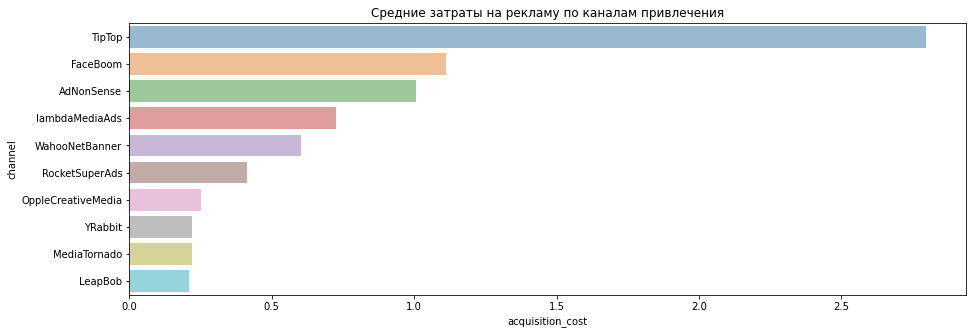

In [25]:
profiles = profiles.query('channel != "organic"')
profiles_channel = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False).reset_index()
display('Cредняя стоимость одного пользователя для каждого источника трафика', profiles_channel)

plt.figure(figsize=(15, 5))
sns.barplot(x="acquisition_cost", y="channel", data=profiles_channel, alpha=0.5).set(title='Средние затраты на рекламу по каналам привлечения')
plt.show()

In [26]:
display('Общая сумма расходов на маркетинг', ad_costs['costs'].sum().round())

'Общая сумма расходов на маркетинг'

105497.0

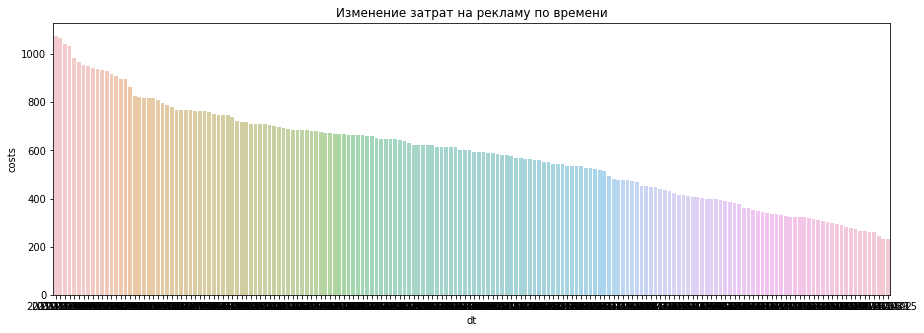

In [27]:
ad_costs_dt = ad_costs.groupby('dt').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
plt.figure(figsize=(15,5))
sns.barplot(x="dt", y="costs", data=ad_costs_dt, alpha=0.5).set(title='Изменение затрат на рекламу по времени')
plt.show()

**Вывод** рекламу составила 

Общая сумма расходов на рекламу составила 105497 $. Нашли среднюю стоимость одного пользователя для каждого источника трафика и для всего проекта и визуализировали затраты на рекламу по дате.



# Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

**Проанализируем общую окупаемость рекламы**

In [28]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

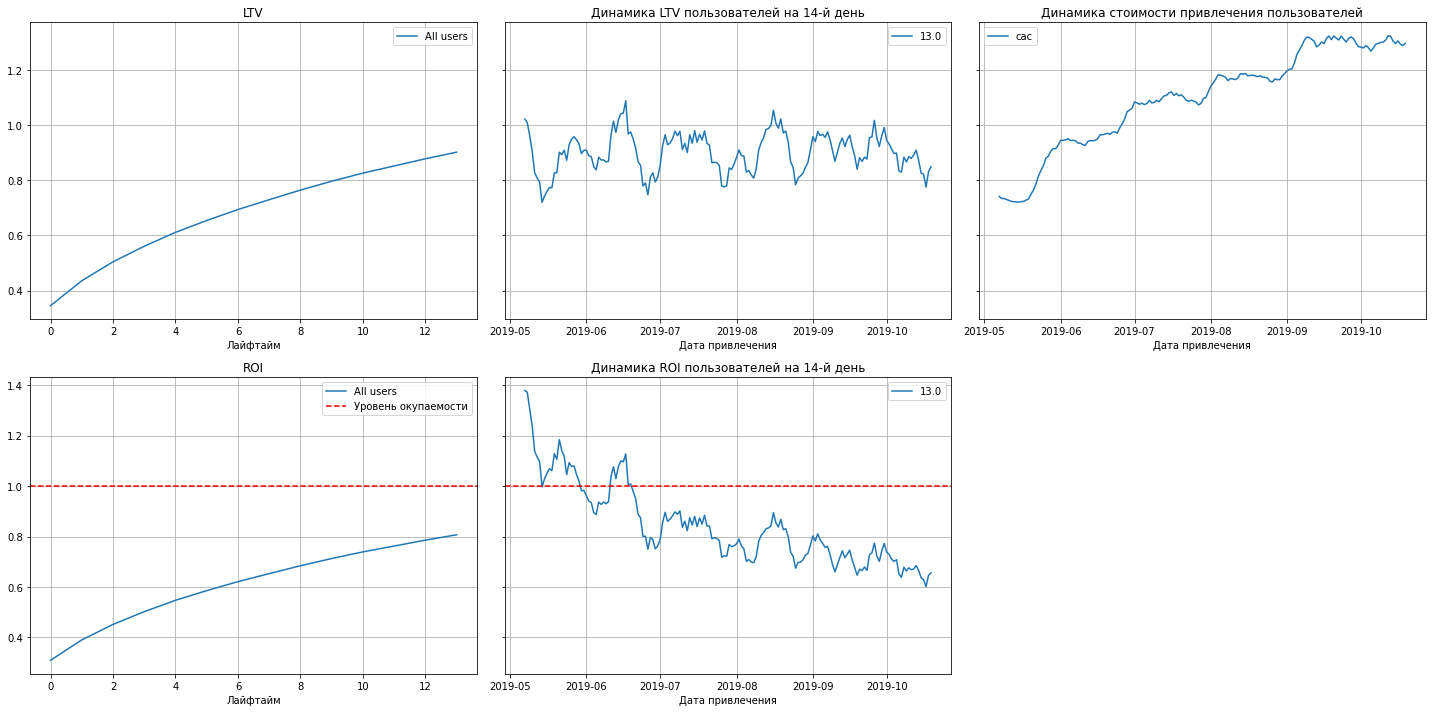

In [29]:
profiles = profiles.query('channel != "organic"')
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchases, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history,horizon_days)

**Вывод**
По графикам можно сделать такой вывод, что Реклама не окупается. ROI в конце недели — около 80%. САС идет на увеличение.

**Проанализируем окупаемость рекламы с разбивкой по странам**

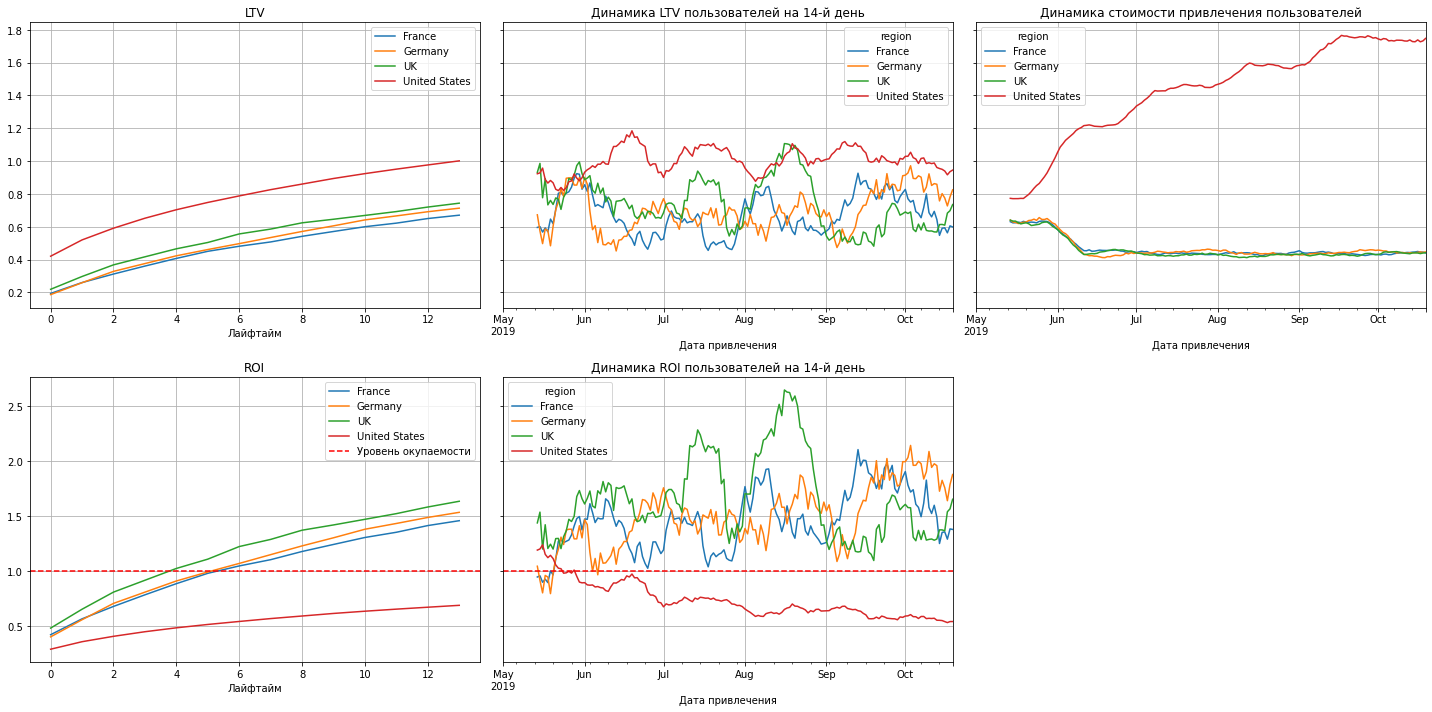

In [30]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод** 

Реклама в United States не окупилась вовсе, самая окупаемая реклама в UK.Стоимость привлечения пользователей не стабильна у United States.

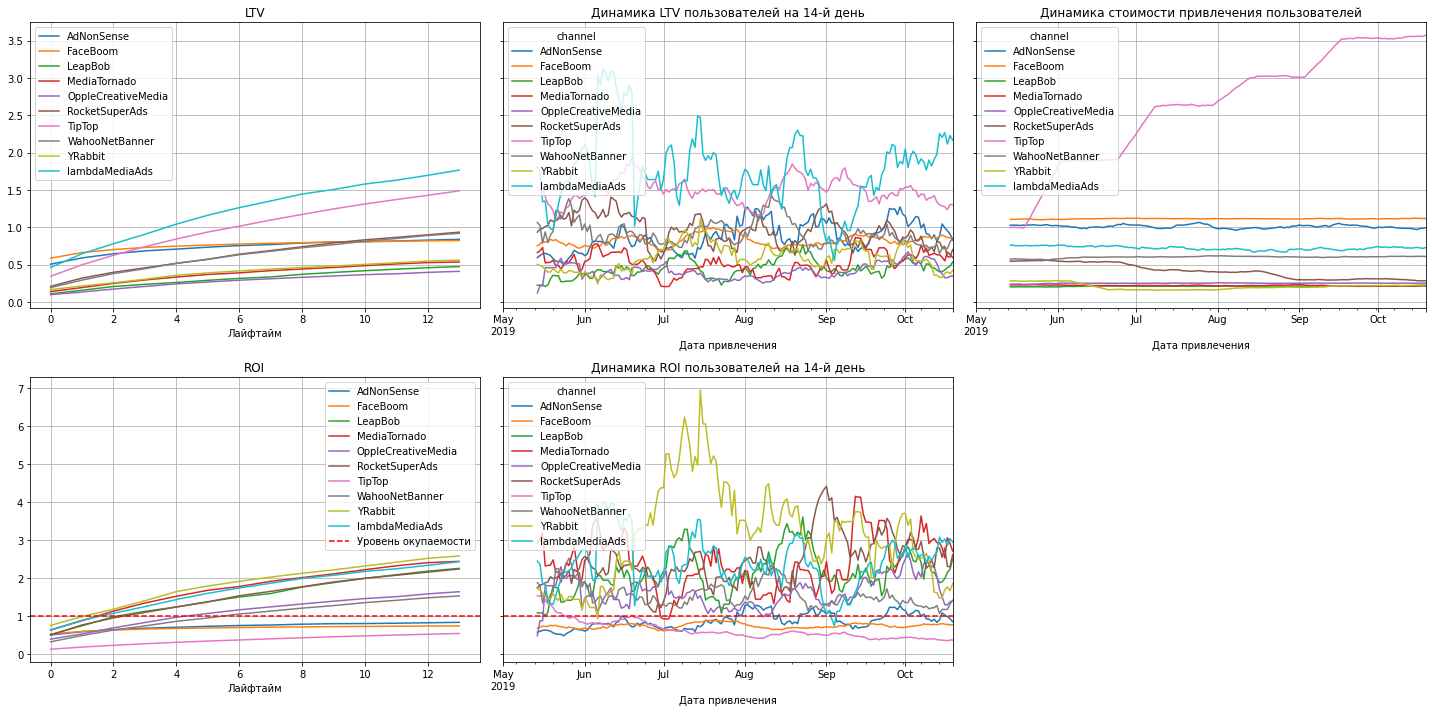

In [31]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод** 

Возможно дело в источниках привлечения  Реклама с каналов самая окупаемая с канала YRabbit, у  канала Tip Top самая убыточная, при том что стоимость привлечения пользователей высокая.

**Проанализируем окупаемость рекламы с разбивкой по устройствам**

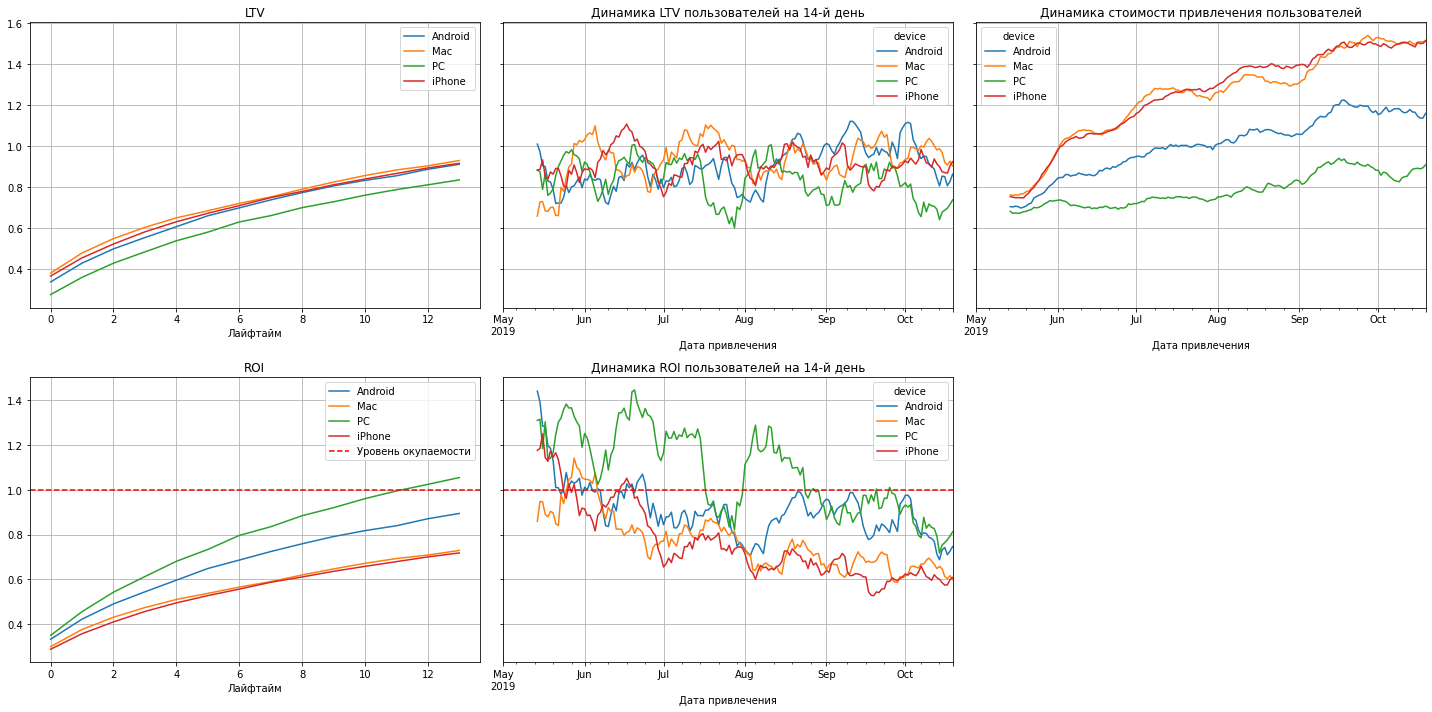

In [32]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchases, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**
Пользователи PC окупаются, а вот Android,Mac, iPhone - нет.


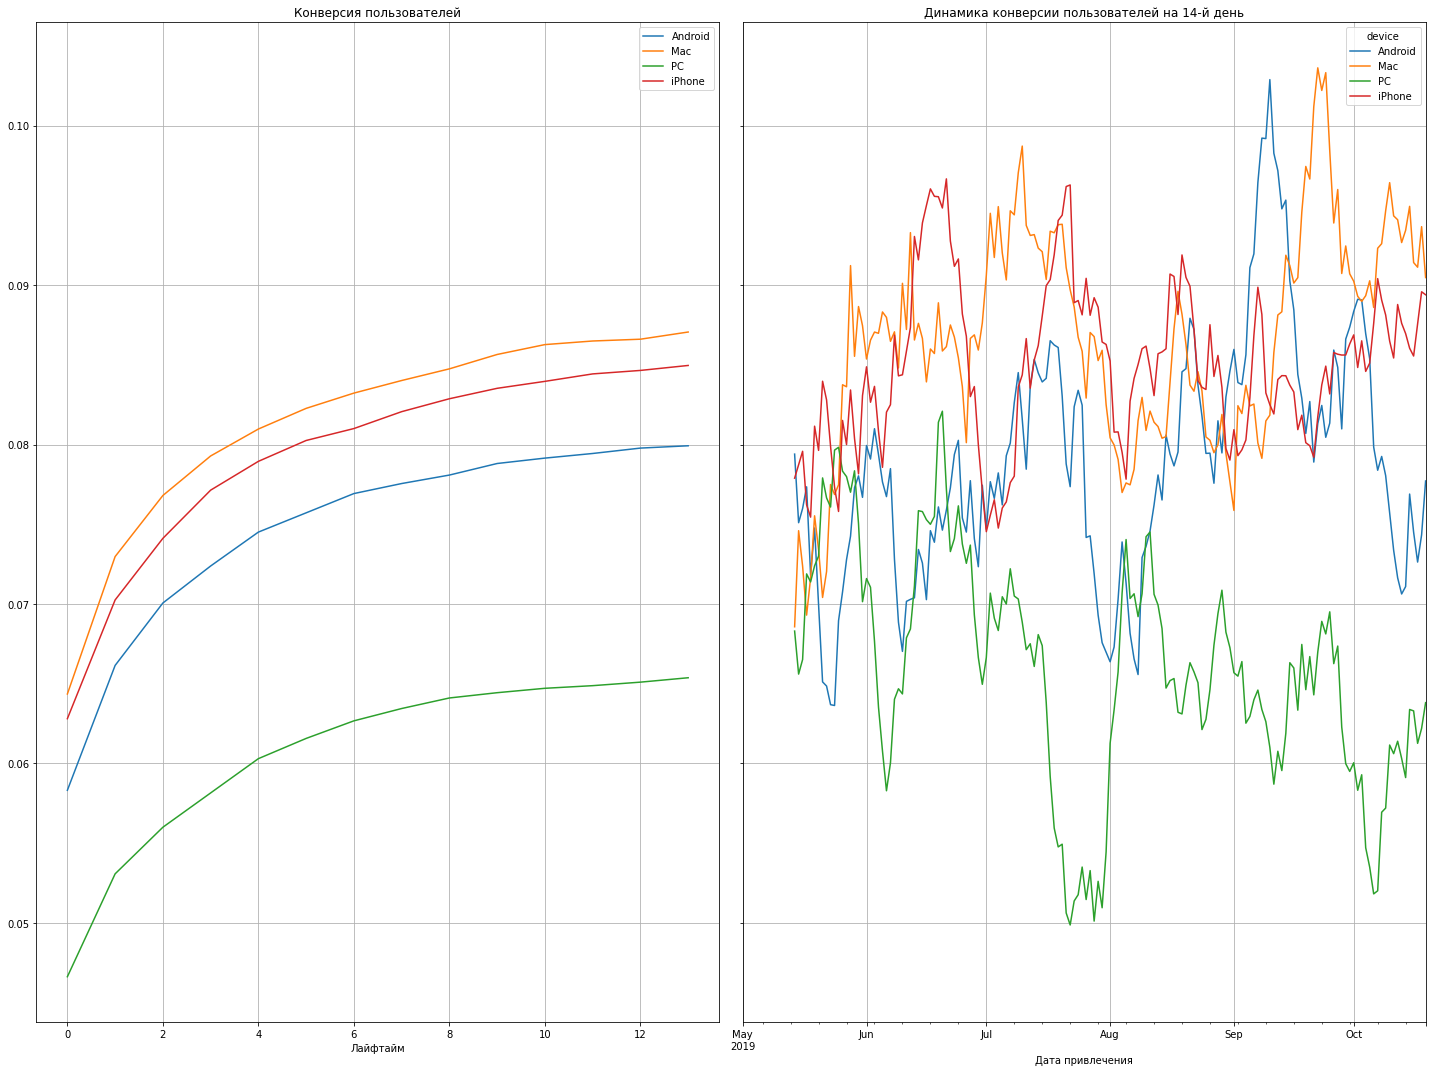

In [33]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, purchases, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**

Пользователи Mac лидеры по конвертации.

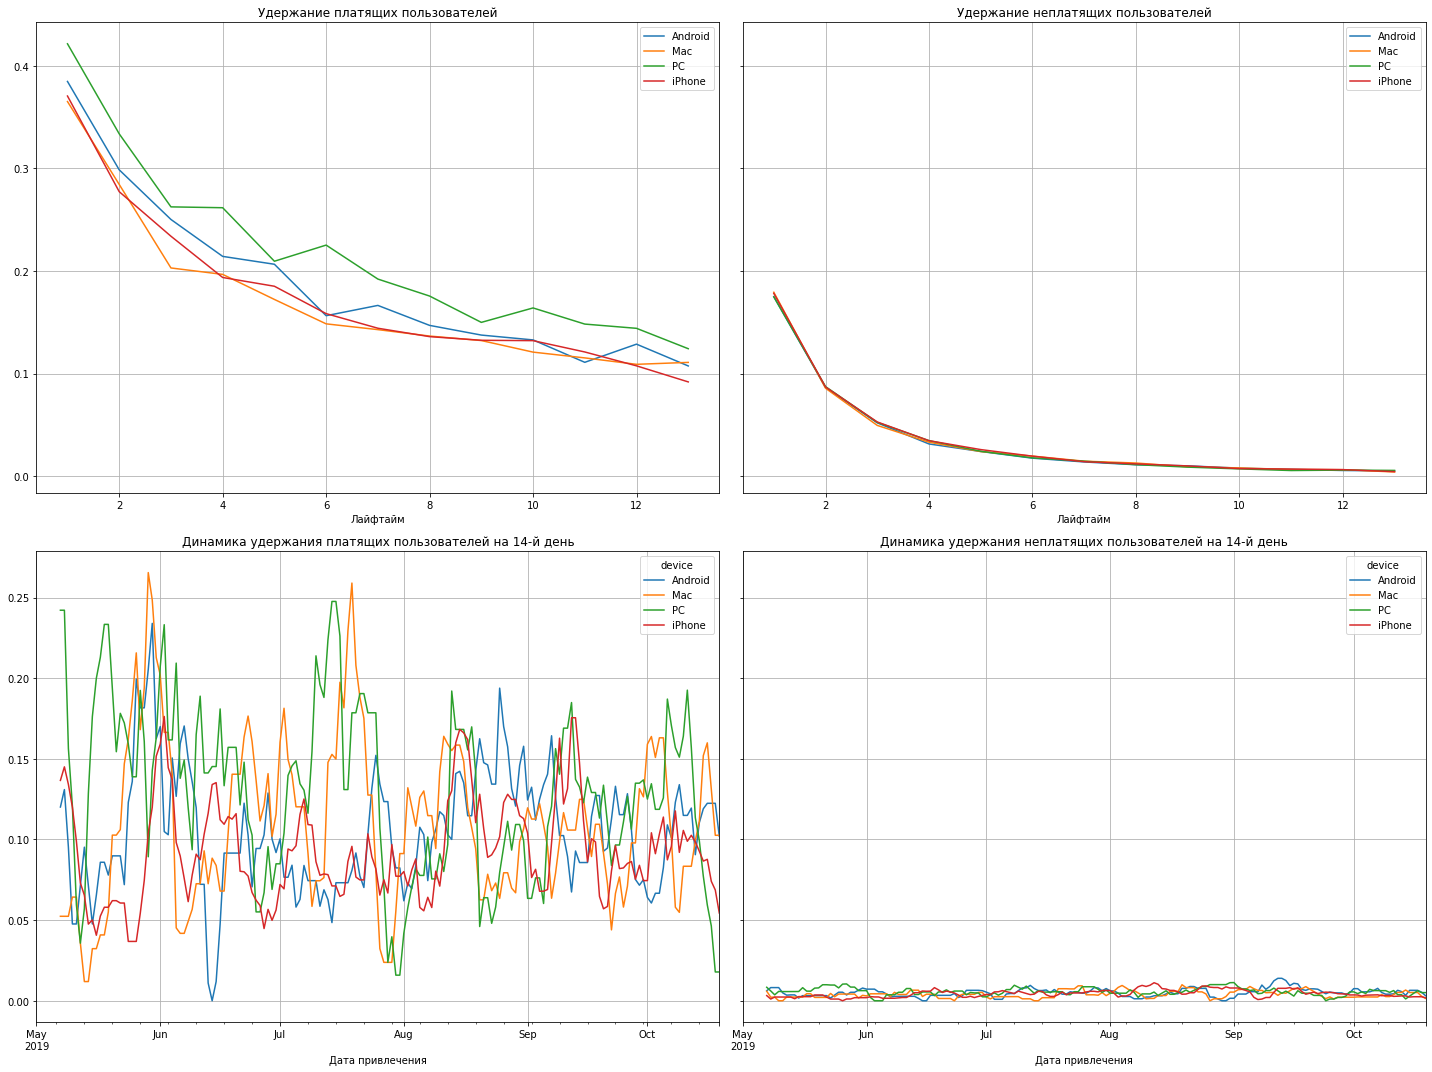

In [34]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

Самое высокое удержание платящих пользователей PC, а пользователи Mac и iPhone самое низкое.



**Общий вывод**

Проанализировав данные выяснили, что общая сумма расходов на рекламу составила 105497 $. Реклама не окупается. ROI в конце недели около 80%. 

Самая окупаемая реклама в Англии(UK).Реклама в США(United States) не окупилась вовсе, но при этом стоимость привлечения пользователей в США высокая.

Самая окупаемая реклама у канала YRabbit. У канала Tip Top самая убыточная, при том что стоимость привлечения пользователей высокая.

Пользователи устройств PC окупаются, при том, что пользователи устройств Mac лидеры по конвертации.

Самое высокое удержание платящих пользователей устройств PC, а пользователи Mac -самое низкое.

Отделу маркетинга рекомендуем перераспределить бюджет и исключить канал Tip Top.


